# ***KMeans Player Clustering***
This notebook explores the application of KMeans clustering to group midfielders based on their playing styles. Using a dataset from Wyscout, we analyze player metrics from the Big 5 European leagues during the 2023-2024 season. The goal is to uncover meaningful clusters that reflect distinct roles and styles.

## Libraries
We begin by installing and importing the necessary libraries.

In [195]:
!pip install kneed adjustText
!pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from kneed import KneeLocator
from adjustText import adjust_text
from sklearn.metrics import silhouette_score, davies_bouldin_score

## EDA
We start by loading the dataset with pandas and inspecting its structure to understand the available data and identify key features for analysis.

In [196]:
# Loading the dataset
df = pd.read_excel('/content/Midfielders_2324_Big5.xlsx')

# Displaying the first few rows to understand the structure of the dataset
df.head()

,Player,Team,Team within selected timeframe,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,...,Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %"
0,N. Mayoka-Tika,Charleroi,Olympique Marseille,RCMF,21,50000,2027-06-30,1,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
1,A. Sodero,Atalanta U23,Empoli,AMF,20,0,2025-06-30,1,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
2,T. Trinker,Cannes,Nice,RCMF,23,0,NaN,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
3,D. Bettella,Frosinone,Monza,LCMF,24,1000000,2025-06-30,1,14,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
4,M. Mladenovic,Vojvodina,Eintracht Frankfurt,RCMF,20,500000,2028-06-30,1,10,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0


We get the overview of the dataset's structure, including the total number of rows, columns, and data types for each column. This information helps assess data completeness and identify potential preprocessing needs.

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Columns: 102 entries, Player to Penalty conversion, %
dtypes: float64(79), int64(14), object(9)
memory usage: 541.2+ KB


We put our dataset's columns in a list for easier handling in the feature selection process.

In [198]:
list(df.columns)

['Player',
 'Team',
 'Team within selected timeframe',
 'Position',
 'Age',
 'Market value',
 'Contract expires',
 'Matches played',
 'Minutes played',
 'Goals',
 'xG',
 'Assists',
 'xA',
 'Duels per 90',
 'Duels won, %',
 'Birth country',
 'Passport country',
 'Foot',
 'Height',
 'Weight',
 'On loan',
 'Successful defensive actions per 90',
 'Defensive duels per 90',
 'Defensive duels won, %',
 'Aerial duels per 90',
 'Aerial duels won, %',
 'Sliding tackles per 90',
 'PAdj Sliding tackles',
 'Shots blocked per 90',
 'Interceptions per 90',
 'PAdj Interceptions',
 'Fouls per 90',
 'Yellow cards',
 'Yellow cards per 90',
 'Red cards',
 'Red cards per 90',
 'Successful attacking actions per 90',
 'Goals per 90',
 'Non-penalty goals',
 'Non-penalty goals per 90',
 'xG per 90',
 'Head goals',
 'Head goals per 90',
 'Shots',
 'Shots per 90',
 'Shots on target, %',
 'Goal conversion, %',
 'Assists per 90',
 'Crosses per 90',
 'Accurate crosses, %',
 'Crosses from left flank per 90',
 'Accur

## Data Cleaning & Feature Selection & EDA in cleaned dataframe
Next, we refine the dataset by cleaning irrelevant or noisy data and selecting features most pertinent to the clustering task.

To enhance clustering accuracy, we filter out data from players with limited playing time, minimizing noise focusing on consistent contributors. This ensures the analysis is based on reliable data. We will only analyze players with minutes played higher than 1800, which is equal to 20 whole matches.

In [199]:
# Filtering out players with less than 1800 minutes played
df = df[df['Minutes played'] > 1800].reset_index(drop=True)

# Displaying the cleaned dataset
df.head()

,Player,Team,Team within selected timeframe,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,...,Deep completions per 90,Deep completed crosses per 90,Progressive passes per 90,"Accurate progressive passes, %",Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %"
0,Gavi,Barcelona,Barcelona,"RCMF, LCMF, LAMF",20,0,2025-06-30,22,1818,4,...,0.79,0.10,2.97,75.00,0.00,0.00,0.0,0.00,0,0.0
1,K. N'Doram,Al Kholood,Metz,"DMF, LDMF",29,1500000,2026-06-30,24,1832,0,...,0.15,0.00,4.81,69.39,0.00,0.00,0.0,0.00,0,0.0
2,R. Khedira,Union Berlin,Union Berlin,"DMF, LCMF, RCMF",31,5000000,2025-06-30,25,1880,0,...,0.34,0.14,3.45,56.94,0.00,0.00,0.0,0.05,0,0.0
3,P. Osterhage,Freiburg,Bochum,"LDMF, DMF, LCMF",25,7000000,2026-06-30,25,2039,2,...,0.62,0.22,4.86,67.27,0.04,0.00,0.0,0.13,0,0.0
4,K. De Bruyne,Manchester City,Manchester City,"AMF, RCMF",33,50000000,2025-06-30,25,1849,6,...,3.16,1.65,7.84,86.34,1.36,0.39,25.0,5.11,0,0.0


We select features based on their relevance to player performance and clustering objectives. This step ensures the analysis focuses on metrics that contribute meaningfully to player roles. We use domain knowledge to clean up the columns that are either not relevant for the clustering process or not useful for our problem, which are:


 * Team,
 * Team within selected timeframe,
 * Age,
 * Market value,
 * Contract expires,
 * Matches played,
 * Minutes played,
 * Goals,
 * xG,
 * Assists,
 * xA,
 * Duels won, %,
 * Birth country,
 * Passport country,
 * Foot,
 * Height,
 * Weight,
 * On loan,
 * Defensive duels won, %,
 * Aerial duels won, %,
 * Sliding tackles per 90,
 * Interceptions per 90,
 * Yellow cards,
 * Yellow cards per 90,
 * Red cards,
 * Red cards per 90,
 * Goals per 90,
 * Non-penalty goals,
 * Head goals,
 * Head goals per 90,
 * Shots,
 * Shots on target, %,
 * Goal conversion, %,
 * Crosses per 90,
 * Accurate crosses, %,
 * Crosses from left flank per 90,
 * Accurate crosses from left flank, %,
 * Crosses from right flank per 90,
 * Accurate crosses from right flank, %,
 * Crosses to goalie box per 90,
 * Successful dribbles, %,
 * Offensive duels won, %,
 * Received passes per 90,
 * Received long passes per 90,
 * Accurate passes, %,
 * Accurate forward passes, %,
 * Accurate back passes, %,
 * Accurate lateral passes, %,
 * Accurate short / medium passes, %,
 * Accurate long passes, %,
 * Average long pass length, m,
 * Accurate smart passes, %,
 * Passes to final third per 90,
 * Accurate passes to final third, %,
 * Passes to penalty area per 90,
 * Accurate passes to penalty area, %,
 * Accurate through passes, %,
 * Deep completed crosses per 90,
 * Accurate progressive passes, %,
 * Free kicks per 90,
 * Direct free kicks per 90,
 * Direct free kicks on target, %,
 * Corners per 90,
 * Penalties taken,
 * Penalty conversion, %

In [200]:
# Selecting relevant features for clustering based on domain knowledge
features = [
    # General Information
    'Player',
    'Position',

    # Defending
    'Successful defensive actions per 90',
    'Defensive duels per 90',
    'PAdj Sliding tackles',
    'Shots blocked per 90',
    'PAdj Interceptions',
    'Fouls per 90',

    # Attacking
    'Dribbles per 90',
    'Offensive duels per 90',
    'Touches in box per 90',
    'Successful attacking actions per 90',

    # Passing
    'Passes per 90',
    'Short / medium passes per 90',
    'Forward passes per 90',
    'Back passes per 90',
    'Lateral passes per 90',
    'Long passes per 90',
    'Average pass length, m',
    'Assists per 90',
    'xA per 90',
    'Shot assists per 90',
    'Second assists per 90',
    'Third assists per 90',
    'Smart passes per 90',
    'Key passes per 90',
    'Through passes per 90',
    'Deep completions per 90',
    'Progressive passes per 90',

    # Shooting
    'Non-penalty goals per 90',
    'xG per 90',
    'Shots per 90',

    # Physical
    'Accelerations per 90',
    'Progressive runs per 90',
    'Duels per 90',
    'Aerial duels per 90',
    'Fouls suffered per 90'
]

# Creating a new DataFrame with the selected features
players = df[features]
players.head()

,Player,Position,Successful defensive actions per 90,Defensive duels per 90,PAdj Sliding tackles,Shots blocked per 90,PAdj Interceptions,Fouls per 90,Dribbles per 90,Offensive duels per 90,...,Deep completions per 90,Progressive passes per 90,Non-penalty goals per 90,xG per 90,Shots per 90,Accelerations per 90,Progressive runs per 90,Duels per 90,Aerial duels per 90,Fouls suffered per 90
0,Gavi,"RCMF, LCMF, LAMF",10.45,9.31,1.46,0.25,7.84,2.43,2.03,7.48,...,0.79,2.97,0.20,0.14,0.84,0.45,2.33,23.66,3.47,1.39
1,K. N'Doram,"DMF, LDMF",8.25,5.90,0.61,0.25,3.85,1.52,1.08,2.65,...,0.15,4.81,0.00,0.02,0.34,0.20,0.29,13.76,2.70,0.98
2,R. Khedira,"DMF, LCMF, RCMF",9.38,6.80,0.64,0.34,4.77,1.77,0.43,2.35,...,0.34,3.45,0.00,0.03,0.19,0.00,0.14,16.13,2.78,0.67
3,P. Osterhage,"LDMF, DMF, LCMF",9.93,6.80,0.63,0.31,6.81,0.93,1.46,5.21,...,0.62,4.86,0.09,0.07,0.93,0.44,1.24,17.88,3.00,1.06
4,K. De Bruyne,"AMF, RCMF",4.19,3.85,0.50,0.15,3.02,0.88,2.97,7.11,...,3.16,7.84,0.29,0.22,3.31,0.97,2.53,14.55,0.92,0.88


We get the overview of our new dataframe.

In [201]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Player                               365 non-null    object 
 1   Position                             365 non-null    object 
 2   Successful defensive actions per 90  365 non-null    float64
 3   Defensive duels per 90               365 non-null    float64
 4   PAdj Sliding tackles                 365 non-null    float64
 5   Shots blocked per 90                 365 non-null    float64
 6   PAdj Interceptions                   365 non-null    float64
 7   Fouls per 90                         365 non-null    float64
 8   Dribbles per 90                      365 non-null    float64
 9   Offensive duels per 90               365 non-null    float64
 10  Touches in box per 90                365 non-null    float64
 11  Successful attacking actions per

We explore our dataset a bit further, getting some statistics for our features. This provides insights into data variability and distribution, aiding preprocessing decisions.

In [202]:
players.describe()

,Successful defensive actions per 90,Defensive duels per 90,PAdj Sliding tackles,Shots blocked per 90,PAdj Interceptions,Fouls per 90,Dribbles per 90,Offensive duels per 90,Touches in box per 90,Successful attacking actions per 90,...,Deep completions per 90,Progressive passes per 90,Non-penalty goals per 90,xG per 90,Shots per 90,Accelerations per 90,Progressive runs per 90,Duels per 90,Aerial duels per 90,Fouls suffered per 90
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.00000,365.000000,365.000000,365.000000
mean,7.719397,6.222027,0.558521,0.232438,4.769096,1.225342,1.802767,5.510000,1.302247,1.850055,...,0.829151,5.675644,0.092740,0.112082,1.110767,0.438548,1.23011,16.660000,2.312466,1.129068
std,2.095819,1.619285,0.443810,0.146059,1.549213,0.459444,1.266819,2.715796,0.923195,1.052390,...,0.511593,1.811225,0.093104,0.084317,0.590224,0.343558,0.72081,3.890735,1.386733,0.530948
min,2.700000,1.940000,0.000000,0.000000,1.810000,0.260000,0.090000,0.900000,0.000000,0.180000,...,0.030000,1.810000,0.000000,0.010000,0.060000,0.000000,0.09000,9.070000,0.300000,0.130000
25%,6.310000,5.050000,0.230000,0.120000,3.660000,0.900000,0.900000,3.490000,0.590000,1.020000,...,0.470000,4.400000,0.030000,0.050000,0.660000,0.180000,0.67000,13.820000,1.450000,0.760000
50%,7.580000,6.110000,0.440000,0.220000,4.680000,1.190000,1.530000,5.000000,1.090000,1.620000,...,0.710000,5.440000,0.070000,0.090000,1.050000,0.360000,1.11000,16.310000,2.030000,1.060000
75%,9.220000,7.300000,0.780000,0.320000,5.700000,1.510000,2.360000,6.810000,1.740000,2.370000,...,1.050000,6.630000,0.140000,0.150000,1.410000,0.610000,1.70000,18.850000,2.850000,1.440000
max,13.860000,11.830000,2.940000,0.770000,9.450000,2.630000,9.830000,19.320000,5.180000,6.760000,...,3.190000,11.960000,0.470000,0.500000,3.310000,1.750000,4.94000,33.850000,13.230000,3.090000


We examine the dataset for missing values to ensure data integrity. Identifying null values at this stage helps avoid errors during analysis.

In [203]:
players.isnull().sum()

,0
Player,0
Position,0
Successful defensive actions per 90,0
Defensive duels per 90,0
PAdj Sliding tackles,0
Shots blocked per 90,0
PAdj Interceptions,0
Fouls per 90,0
Dribbles per 90,0
Offensive duels per 90,0


We check for duplicate rows in our dataset.

In [204]:
players.duplicated().sum()

np.int64(0)

We check for duplicate players in our dataset.

In [205]:
players.duplicated(subset=['Player']).sum()

np.int64(0)

We removeplayer identifiers and positions to focus solely on numerical features for clustering. These columns are stored separately for visualization and interpretative purposes.

In [206]:
player_names = players.Player.tolist()
player_positions = players.Position.tolist()
players = players.drop(['Player', 'Position'], axis = 1)
players.head()

,Successful defensive actions per 90,Defensive duels per 90,PAdj Sliding tackles,Shots blocked per 90,PAdj Interceptions,Fouls per 90,Dribbles per 90,Offensive duels per 90,Touches in box per 90,Successful attacking actions per 90,...,Deep completions per 90,Progressive passes per 90,Non-penalty goals per 90,xG per 90,Shots per 90,Accelerations per 90,Progressive runs per 90,Duels per 90,Aerial duels per 90,Fouls suffered per 90
0,10.45,9.31,1.46,0.25,7.84,2.43,2.03,7.48,2.13,1.83,...,0.79,2.97,0.20,0.14,0.84,0.45,2.33,23.66,3.47,1.39
1,8.25,5.90,0.61,0.25,3.85,1.52,1.08,2.65,0.39,0.98,...,0.15,4.81,0.00,0.02,0.34,0.20,0.29,13.76,2.70,0.98
2,9.38,6.80,0.64,0.34,4.77,1.77,0.43,2.35,0.19,0.24,...,0.34,3.45,0.00,0.03,0.19,0.00,0.14,16.13,2.78,0.67
3,9.93,6.80,0.63,0.31,6.81,0.93,1.46,5.21,1.32,1.15,...,0.62,4.86,0.09,0.07,0.93,0.44,1.24,17.88,3.00,1.06
4,4.19,3.85,0.50,0.15,3.02,0.88,2.97,7.11,5.06,5.69,...,3.16,7.84,0.29,0.22,3.31,0.97,2.53,14.55,0.92,0.88


To better understand the data before clustering, we visualize the distribution of each feature. This helps us choose the right scaling method and see how different playing styles appear across metrics. Outliers are kept, as they may reflect unique stylistic roles rather than noise.

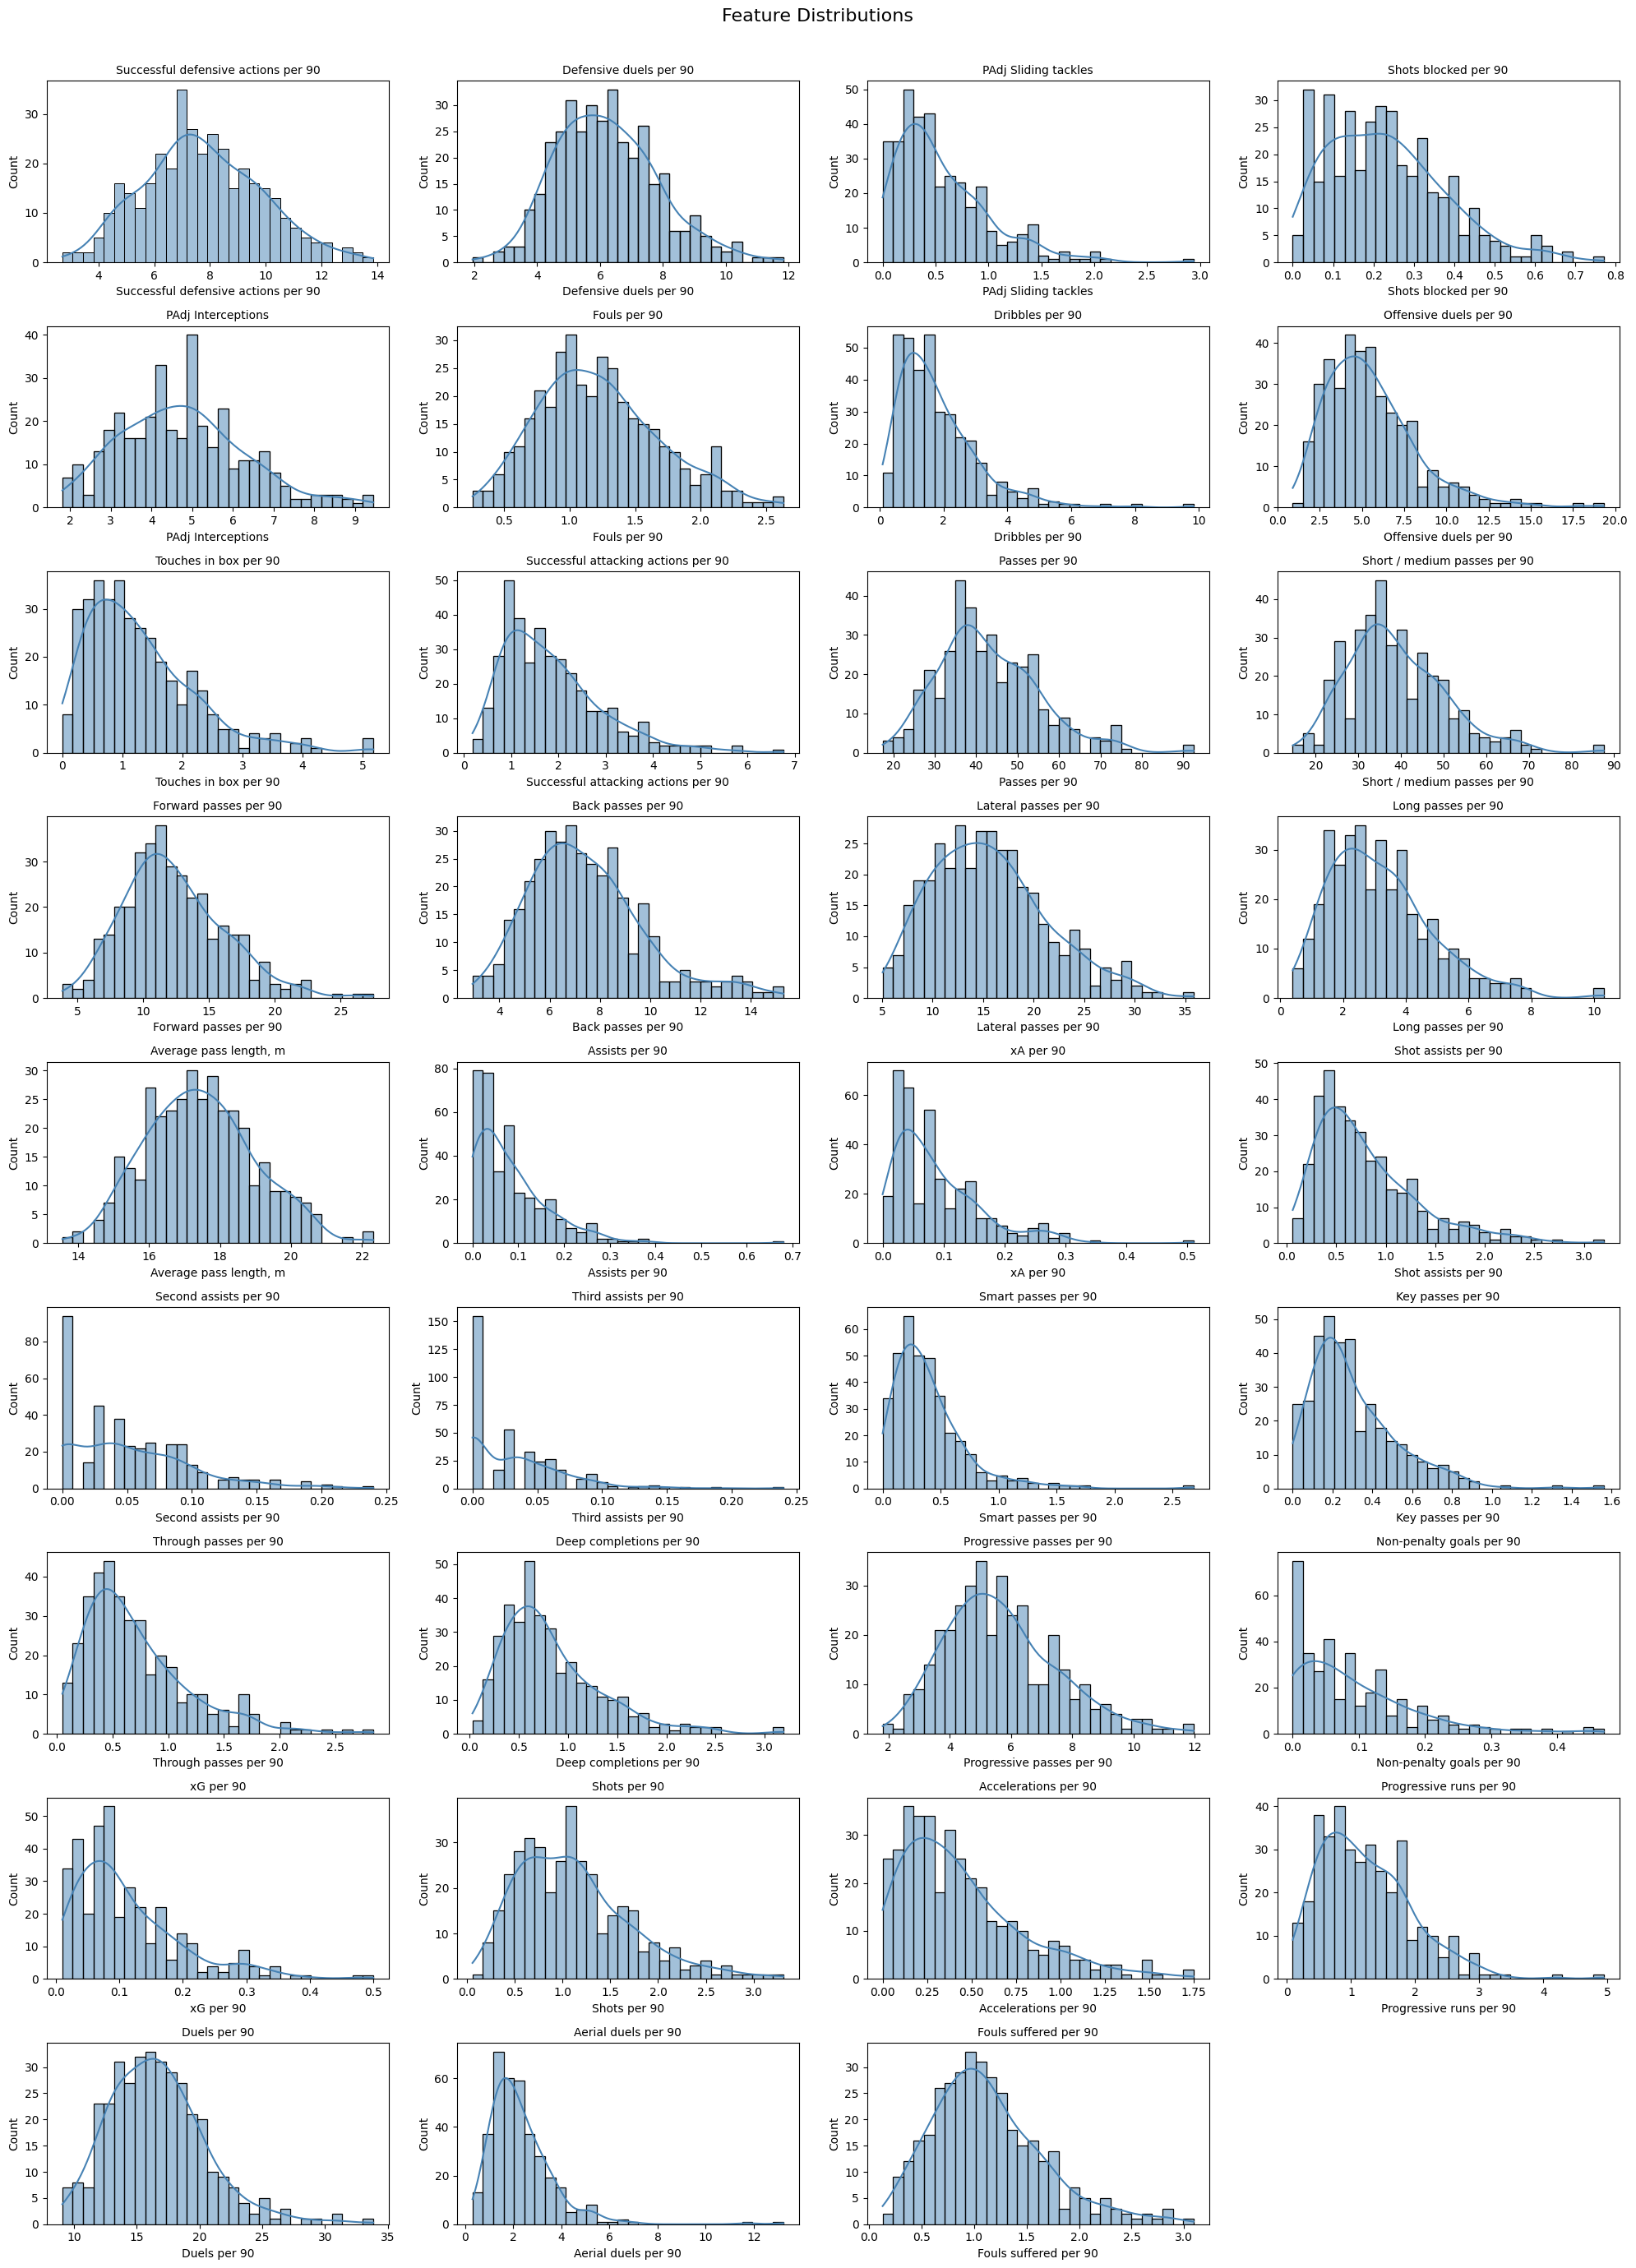

In [207]:
# Plot histograms in a grid
n_cols = 4
n_rows = -(-len(players.columns) // n_cols)  # Ceiling division
plt.figure(figsize=(20, n_rows * 3))

for i, feature in enumerate(players.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(players[feature], kde=True, bins=30, color='steelblue')
    plt.title(feature, fontsize=10)
    plt.tight_layout()

plt.suptitle("Feature Distributions", fontsize=16, y=1.02)
plt.show()

## Data Normalization & PCA
To enhance analytical efficiency, we normalize the data and utilize PCA for dimensionality reduction, condensing the dataset into a manageable two-dimensional format.

We Normalize our data using Standard scaling. Normalization adjusts all features to a standard scale, ensuring equal contribution to the clustering process. It mitigates bias from features with larger magnitudes.

In [208]:
# Normalizing the data to ensure all features contribute equally to the clustering process
x = players.values
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Converting the normalized data back into a DataFrame for easier handling
X_norm = pd.DataFrame(x_scaled, columns=players.columns)
X_norm.head()

,Successful defensive actions per 90,Defensive duels per 90,PAdj Sliding tackles,Shots blocked per 90,PAdj Interceptions,Fouls per 90,Dribbles per 90,Offensive duels per 90,Touches in box per 90,Successful attacking actions per 90,...,Deep completions per 90,Progressive passes per 90,Non-penalty goals per 90,xG per 90,Shots per 90,Accelerations per 90,Progressive runs per 90,Duels per 90,Aerial duels per 90,Fouls suffered per 90
0,1.304669,1.909615,2.034015,0.120401,1.984956,2.625590,0.179619,0.726382,0.897849,-0.019083,...,-0.076632,-1.495870,1.153633,0.331559,-0.459383,0.033379,1.528004,1.801616,0.835866,0.492119
1,0.253520,-0.199143,0.116153,0.120401,-0.594081,0.642216,-0.571320,-1.054544,-0.989498,-0.827877,...,-1.329345,-0.478589,-0.997458,-1.093592,-1.307682,-0.695298,-1.306032,-0.746384,0.279842,-0.281145
2,0.793428,0.357421,0.183843,0.737435,0.000584,1.187099,-1.085120,-1.165160,-1.206434,-1.532004,...,-0.957446,-1.230493,-0.997458,-0.974829,-1.562172,-1.278240,-1.514417,-0.136408,0.337611,-0.865807
3,1.056216,0.357421,0.161280,0.531757,1.319189,-0.643708,-0.270944,-0.110616,0.019257,-0.666118,...,-0.409384,-0.450945,-0.029467,-0.499779,-0.306689,0.004232,0.013740,0.313996,0.496475,-0.130264
4,-1.686330,-1.466871,-0.132040,-0.565192,-1.130572,-0.752685,0.922653,0.589955,4.075968,3.653795,...,4.562319,1.196608,2.121624,1.281660,3.731214,1.549029,1.805851,-0.543058,-1.005512,-0.469745


We use PCA to reduce our dimensions. We choose 2 dimensions to visualize the data in a 2D plot with the results of KMeans. PCA condenses the dataset into two dimensions that capture the most variance. This simplification facilitates clustering and intuitive visualization.

In [209]:
# Applying PCA to reduce the dataset to two dimensions for visualization and clustering
pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(X_norm)

# Creating a DataFrame for the reduced dimensions
reduced = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced.head()

,PC1,PC2
0,-0.437015,-2.156429
1,-3.501698,-2.175632
2,-4.357951,-2.559899
3,-1.541809,-1.903214
4,14.168200,7.161048


## KMeans Clustering
We find the optimal number of clusters and perform the clustering.

While before it wasn't possible to have a 2D analysis with all the features of each player, after PCA, it becomes feasible. Now that we have a 2D metric of similarity, we can apply KMeans to create similarity clusters. However, first, we need to determine how many clusters we want. We use the elbow method to find the optimal number of clusters.

Apart from observing the plot, to take the human eye out of the equation, we can also use the KneeLocator function to help us find the optimal number of clusters. This function identifies the ideal number of clusters by analyzing within-cluster sum of squares (WCSS). This ensures clusters are cohesive and meaningful.

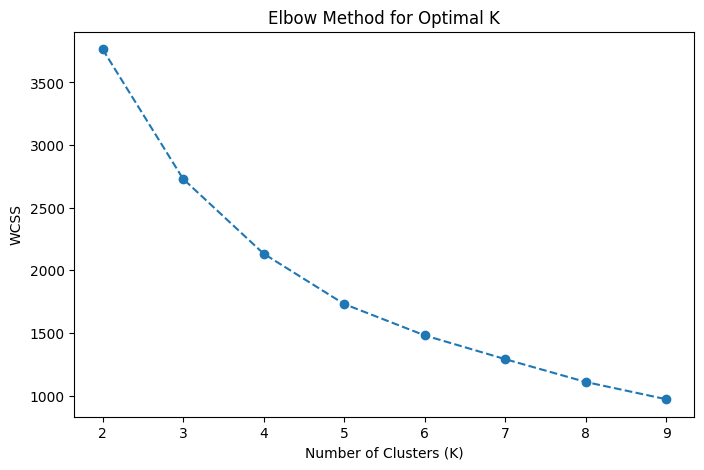


Optimal K (KneeLocator): 5


In [210]:
# Compute WCSS for multiple k values
wcss = []
k_values = range(2, 10)

# Iterate through different cluster numbers
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10)
    kmeans.fit(reduced)
    wcss.append(kmeans.inertia_)

# Find optimal k using KneeLocator
kneedle = KneeLocator(list(k_values), wcss, curve="convex", direction="decreasing")
optimal_k_elbow = kneedle.elbow

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

print(f"\nOptimal K (KneeLocator): {optimal_k_elbow}")

The elbow method indicates an optimal number of five clusters, balancing within-cluster variance and interpretability. Let's proceed to train a KMeans model for K=5 and observe its behavior.

In [211]:
# Performing KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k_elbow, random_state=42, init='k-means++', n_init=10)
kmeans = kmeans.fit(reduced)

# Assigning cluster labels to each data point
labels = kmeans.predict(reduced)
clusters = kmeans.labels_.tolist()

After training and using the trained model, each player in the dataset now has a number from 0 to 4, representing their cluster based on similarities in their profiles. Let's add this information to our reduced dataset and then create a plot with the KMeans results.

In [212]:
# Add cluster labels to the reduced dataset
reduced['Cluster'] = clusters
reduced['Player'] = player_names
reduced['Position'] = player_positions
reduced.columns = ['x', 'y', 'Cluster', 'Player', 'Position']
reduced.head()

,x,y,Cluster,Player,Position
0,-0.437015,-2.156429,4,Gavi,"RCMF, LCMF, LAMF"
1,-3.501698,-2.175632,1,K. N'Doram,"DMF, LDMF"
2,-4.357951,-2.559899,1,R. Khedira,"DMF, LCMF, RCMF"
3,-1.541809,-1.903214,1,P. Osterhage,"LDMF, DMF, LCMF"
4,14.168200,7.161048,3,K. De Bruyne,"AMF, RCMF"


Here is the clustering result of all the players in the dataset. The scatter plot visualizes the clustering results, with each color representing a distinct cluster. This helps interpret player roles based on their metrics.

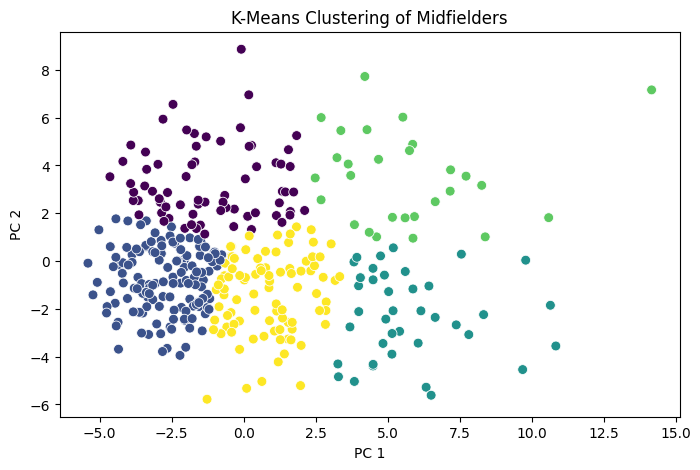

In [213]:
# Visualizing clustering results with selected features
plt.figure(figsize=(8, 5))
scatter_plot=sns.scatterplot(x='x', y='y', data=reduced, legend=False, hue=reduced['Cluster'], palette='viridis', s=50)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("K-Means Clustering of Midfielders")
plt.show()

Cluster visualization with player annotations provides a clearer understanding of how individual players are grouped. Each cluster color represents a distinct player role. Each cluster represents players with similar styles and roles, as determined by their metrics.

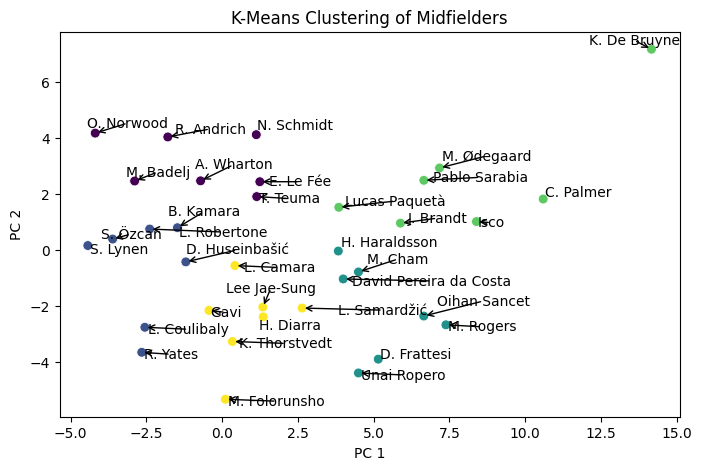

In [214]:
# Select a subset of players for visualization
# Number of players to select per cluster
n_players_per_cluster = 7  # Or any desired number

# Sample from each cluster separately and concatenate
vis_sample = pd.concat([
    group.sample(n=n_players_per_cluster, random_state=42)
    for _, group in reduced.groupby('Cluster')
])

# Visualizing clusters with player names for clarity
plt.figure(figsize=(8, 5))
sns.scatterplot(x='x', y='y', data=vis_sample, legend=False, hue=vis_sample['Cluster'], palette='viridis', s=50)

# Annotating player names in the plot
texts = []
for x, y, s in zip(vis_sample.x, vis_sample.y, vis_sample.Player):
    texts.append(plt.text(x, y, s))

#Adjust text
adjust_text(texts, strategy='best', expand_points=(1.2, 1.2),
            expand_text=(1.2, 1.2), arrowprops=dict(arrowstyle='->', color='black'))

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('K-Means Clustering of Midfielders')
plt.show()

Here is the list of players in each cluster of the plot.

In [215]:
for cluster in range(optimal_k_elbow):
    cluster_players = vis_sample[vis_sample["Cluster"] == cluster][["Player", "Cluster", "Position"]].reset_index(drop=True)
    print(f"\nCluster {cluster}:")
    print(cluster_players)


Cluster 0:
       Player  Cluster          Position
0   E. Le Fée        0        RCMF, LCMF
1  N. Schmidt        0         RCMF, AMF
2  R. Andrich        0    RCMF, LCMF, CB
3  O. Norwood        0   DMF, LCMF, RCMF
4  A. Wharton        0  RCMF, LCMF, RDMF
5   M. Badelj        0               DMF
6    T. Teuma        0         LCMF, AMF

Cluster 1:
           Player  Cluster          Position
0        S. Özcan        1   DMF, LCMF, LDMF
1        R. Yates        1        RDMF, RCMF
2  D. Huseinbašić        1        RDMF, LDMF
3       B. Kamara        1        RCMF, RDMF
4    L. Robertone        1  LDMF, LCMF, RCMF
5        S. Lynen        1   DMF, LCMF, RCMF
6    L. Coulibaly        1        RCMF, LCMF

Cluster 2:
                   Player  Cluster        Position
0             D. Frattesi        2            RCMF
1               M. Rogers        2   AMF, LW, LAMF
2  David Pereira da Costa        2  AMF, LWF, LCMF
3                 M. Cham        2    AMF, RW, RWF
4           H. Harald

To evaluate the quality of the clustering, we can compute internal metrics like the Silhouette Score and Davies-Bouldin Score. A higher Silhouette Score indicates better-defined clusters, while a lower Davies-Bouldin Score signifies more compact and separated clusters.

In [216]:
# Calculating internal clustering evaluation metrics
sil_score = silhouette_score(reduced[['x', 'y']], labels)
db_score = davies_bouldin_score(reduced[['x', 'y']], labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Score: {db_score:.4f}")

Silhouette Score: 0.3389
Davies-Bouldin Score: 0.9107


We can also calculate the mean values of features within each cluster to summarize the characteristics of players in different groups. This provides insights into the defining attributes of each cluster.

In [217]:
# Adding cluster labels to the normalized dataset
X_norm['Cluster'] = labels

# Calculating average feature statistics for each cluster
cluster_summary = X_norm.groupby('Cluster').mean()
cluster_summary

,Successful defensive actions per 90,Defensive duels per 90,PAdj Sliding tackles,Shots blocked per 90,PAdj Interceptions,Fouls per 90,Dribbles per 90,Offensive duels per 90,Touches in box per 90,Successful attacking actions per 90,...,Deep completions per 90,Progressive passes per 90,Non-penalty goals per 90,xG per 90,Shots per 90,Accelerations per 90,Progressive runs per 90,Duels per 90,Aerial duels per 90,Fouls suffered per 90
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.144036,-0.050726,0.138717,0.206590,0.341501,-0.379674,-0.450605,-0.450104,-0.582122,-0.317045,...,0.136161,1.198346,-0.322937,-0.426825,-0.376977,-0.332209,-0.078942,-0.616704,-0.466716,-0.285186
1,0.721517,0.542718,0.293552,0.532254,0.558996,0.408627,-0.551730,-0.540391,-0.563878,-0.707971,...,-0.694053,-0.188652,-0.515801,-0.542809,-0.595971,-0.571106,-0.681179,0.026502,0.368641,-0.121654
2,-1.227524,-0.775052,-0.603551,-1.016980,-1.161896,-0.369311,1.662648,1.487555,1.601224,1.631931,...,0.925638,-0.901322,1.716226,1.634902,1.402525,1.413009,1.291835,0.689563,-0.171198,0.587870
3,-1.076629,-0.878283,-0.471292,-0.978996,-0.791687,-0.823520,0.693702,0.637362,1.062876,1.329361,...,2.065283,0.956505,0.635067,1.014444,1.300837,0.559068,1.049711,-0.320338,-0.838138,0.153311
4,-0.351476,-0.183614,-0.149840,-0.231536,-0.372949,0.084982,0.260158,0.335782,0.292838,0.211397,...,-0.085332,-0.549786,0.100794,0.140219,0.194561,0.347844,0.219501,0.239872,0.132692,0.105906


## PCA Loadings Interpretation
We now explain the PCA results using the PCA Loadings. PCA loadings quantify how much each original feature contributes to each principal component, helping interpret the reduced dimensions. Higher absolute values indicate stronger influences on the respective components.

We get and display the loadings.

In [218]:
# Extracting PCA loadings to interpret feature contributions
pca_loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=[f for f in features if f != 'Player' and f!= 'Position'])

# Adding absolute values for easier comparison
pca_loadings[['Abs_PC1', 'Abs_PC2']] = pca_loadings[['PC1', 'PC2']].abs()

# Displaying the DataFrame
pca_loadings

,PC1,PC2,Abs_PC1,Abs_PC2
Successful defensive actions per 90,-0.222245,-0.008076,0.222245,0.008076
Defensive duels per 90,-0.156101,-0.060069,0.156101,0.060069
PAdj Sliding tackles,-0.106838,0.025362,0.106838,0.025362
Shots blocked per 90,-0.175920,-0.008243,0.175920,0.008243
PAdj Interceptions,-0.196190,0.060825,0.196190,0.060825
Fouls per 90,-0.100711,-0.142350,0.100711,0.142350
Dribbles per 90,0.220495,-0.095512,0.220495,0.095512
Offensive duels per 90,0.202595,-0.102609,0.202595,0.102609
Touches in box per 90,0.235337,-0.097230,0.235337,0.097230
Successful attacking actions per 90,0.262266,-0.017431,0.262266,0.017431


We sort features by their absolute contributions to PC1. It highlights which features most strongly define the primary axis of the reduced dataset.

In [219]:
# Sorting features by their contribution to PC1
top_features_pc1 = pca_loadings[['Abs_PC1', 'PC1', 'PC2']].sort_values(by=['Abs_PC1'], ascending=False)
top_features_pc1

,Abs_PC1,PC1,PC2
Successful attacking actions per 90,0.262266,0.262266,-0.017431
Key passes per 90,0.245580,0.245580,0.096118
Touches in box per 90,0.235337,0.235337,-0.097230
xA per 90,0.233532,0.233532,0.122750
Shot assists per 90,0.232999,0.232999,0.145134
Deep completions per 90,0.232573,0.232573,0.143346
Shots per 90,0.230218,0.230218,-0.029773
Progressive runs per 90,0.223973,0.223973,0.024479
Successful defensive actions per 90,0.222245,-0.222245,-0.008076
Dribbles per 90,0.220495,0.220495,-0.095512


We sort features by their absolute contributions to PC2. Similarly, this ranking identifies the features that play a major role in shaping PC2, providing further insights into the data structure.

In [220]:
# Sorting features by their contribution to PC2
top_features_pc2 = pca_loadings[['Abs_PC2', 'PC2', 'PC1']].sort_values(by=['Abs_PC2'], ascending=False)
top_features_pc2

,Abs_PC2,PC2,PC1
Passes per 90,0.347445,0.347445,-0.049583
Progressive passes per 90,0.337650,0.337650,-0.044057
Forward passes per 90,0.334665,0.334665,-0.084568
Short / medium passes per 90,0.326622,0.326622,-0.050990
Lateral passes per 90,0.314540,0.314540,-0.094186
Through passes per 90,0.243186,0.243186,0.114506
Long passes per 90,0.241299,0.241299,-0.089549
Back passes per 90,0.206377,0.206377,0.080741
Duels per 90,0.191278,-0.191278,0.037874
Aerial duels per 90,0.169808,-0.169808,-0.088944


We sort and display the loadings for the Features where Abs_PC1 > Abs_PC2.

In [221]:
pca_loadings[pca_loadings['Abs_PC1'] > pca_loadings['Abs_PC2']].sort_values(by=['Abs_PC1'], ascending=False)

,PC1,PC2,Abs_PC1,Abs_PC2
Successful attacking actions per 90,0.262266,-0.017431,0.262266,0.017431
Key passes per 90,0.245580,0.096118,0.245580,0.096118
Touches in box per 90,0.235337,-0.097230,0.235337,0.097230
xA per 90,0.233532,0.122750,0.233532,0.122750
Shot assists per 90,0.232999,0.145134,0.232999,0.145134
Deep completions per 90,0.232573,0.143346,0.232573,0.143346
Shots per 90,0.230218,-0.029773,0.230218,0.029773
Progressive runs per 90,0.223973,0.024479,0.223973,0.024479
Successful defensive actions per 90,-0.222245,-0.008076,0.222245,0.008076
Dribbles per 90,0.220495,-0.095512,0.220495,0.095512


We sort and display the loadings for the Features where Abs_PC2 > Abs_PC1.

In [222]:
pca_loadings[pca_loadings['Abs_PC2'] > pca_loadings['Abs_PC1']].sort_values(by=['Abs_PC2'], ascending=False)

,PC1,PC2,Abs_PC1,Abs_PC2
Passes per 90,-0.049583,0.347445,0.049583,0.347445
Progressive passes per 90,-0.044057,0.337650,0.044057,0.337650
Forward passes per 90,-0.084568,0.334665,0.084568,0.334665
Short / medium passes per 90,-0.050990,0.326622,0.050990,0.326622
Lateral passes per 90,-0.094186,0.314540,0.094186,0.314540
Through passes per 90,0.114506,0.243186,0.114506,0.243186
Long passes per 90,-0.089549,0.241299,0.089549,0.241299
Back passes per 90,0.080741,0.206377,0.080741,0.206377
Duels per 90,0.037874,-0.191278,0.037874,0.191278
Aerial duels per 90,-0.088944,-0.169808,0.088944,0.169808


### **PCA Axis Interpretation**

**PC1 (horizontal axis)**

A player's positioning further to the right on the PC1 axis indicates a stronger attacking orientation in their profile. Conversely, the further to the left, the more defensive-oriented they are.
Negative values on PC1 reflect a player’s contribution to defensive actions (e.g., interceptions, tackles, defensive duels), whereas positive values reflect attacking actions, particularly those that take place in the final third and directly support goal-scoring (e.g., xG, xA, key passes, deep completions).
General passes (e.g., lateral or backward passes) do not significantly affect this axis. In contrast, smart passes that directly lead to scoring opportunities contribute strongly in the positive direction.

**PC2 (vertical axis)**

The higher a player appears on the PC2 axis, the more involved they are in their team’s passing game — often reflected through pass volume, progressiveness, and involvement in build-up play.
Lower values indicate players who are less involved in circulation and more engaged in direct actions such as dribbling, shooting, finishing, or duels. Defensive contributions have minimal impact on this axis.


### **Cluster Interpretation**

**Cluster 0 (purple) | Defensive Midfielders: Deep-Lying Playmakers**

Cluster members predominantly function as central or defensive midfielders, specializing in ball distribution and initiating plays from deeper areas. They are instrumental in ball distribution and maintaining possession, often acting as the link between defense and attack. Their involvement in the team's passing game is substantial, although they contribute less directly to goal-scoring. This aligns with the 'Deep-Lying Playmaker' role.

**Cluster 1 (dark blue) | Defensive Midfielders: Holding Midfielders**

This group consists of players who are predominantly defensive-minded, focusing on breaking up opposition plays and providing a shield to the defense. Their primary contributions are in defensive actions, with limited involvement in offensive build-up or goal-scoring. Positions associated with these responsibilities include 'Holding Midfielder' and 'Defensive Midfielder'.

**Cluster 2 (light blue) | Attacking Midfielders: False 10s**

Players in this cluster are attack-oriented midfielders who contribute significantly to goal-scoring opportunities but are less involved in the team's overall passing rhythm. They often possess high technical skills and operate in advanced positions, sometimes on the flanks or supporting the main striker. This corresponds to roles like False 10s or Central Wingers.

**Cluster 3 (green) | Attacking Midfielders: Advanced Playmakers**

This cluster includes players who are highly involved in both creating and converting goal-scoring opportunities. They play a central role in the team's offensive play, often positioned just behind the main striker. Their skill set aligns with the 'Advanced Playmaker' or 'Trequartista' roles, emphasizing creativity and offensive contribution.

**Cluster 4 (yellow) | Central Midfielders: Box-to-Box Midfielders**

Players here exhibit a balance between defensive and offensive duties. They contribute to the team's play across the pitch, engaging in defensive actions while also supporting attacks. Their versatility is indicative of the 'Box-to-Box Midfielder' role, covering large areas of the field and participating in various phases of play through late runs into the box or final passes.

# **Feature Correlation**
We analyze feature correlations to uncover relationships and consider reapplying the procedure after eliminating highly correlated features. For the purposes of this analysis, we only calculate correlations for observation and do not repeat the process.

We analyze feature correlations to detect redundancy. Highly correlated pairs are noted for potential removal, as they may not add unique value to the clustering process, using a threshold of our choice. In this example, we use a threshold of 0.7.

In [223]:
# Computing correlation matrix for selected features
corr_matrix = X_norm.corr().abs()

# Identifying highly correlated feature pairs
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix[i][j] > 0.7]

# Displaying highly correlated feature pairs
print("Highly Correlated Features (Correlation > 0.7):\n")
for pair in high_corr_pairs:
    print(f"{pair[0]} | {pair[1]}\n")

Highly Correlated Features (Correlation > 0.7):

Successful defensive actions per 90 | Defensive duels per 90

Successful defensive actions per 90 | PAdj Interceptions

Defensive duels per 90 | Successful defensive actions per 90

PAdj Interceptions | Successful defensive actions per 90

Dribbles per 90 | Offensive duels per 90

Dribbles per 90 | Successful attacking actions per 90

Dribbles per 90 | Progressive runs per 90

Offensive duels per 90 | Dribbles per 90

Offensive duels per 90 | Successful attacking actions per 90

Touches in box per 90 | Non-penalty goals per 90

Touches in box per 90 | xG per 90

Successful attacking actions per 90 | Dribbles per 90

Successful attacking actions per 90 | Offensive duels per 90

Successful attacking actions per 90 | Key passes per 90

Successful attacking actions per 90 | Shots per 90

Successful attacking actions per 90 | Progressive runs per 90

Passes per 90 | Short / medium passes per 90

Passes per 90 | Forward passes per 90

Passes p

We visualize the Correlation Matrix for our selected Features. The heatmap visualizes relationships between features, highlighting clusters of strongly correlated metrics.

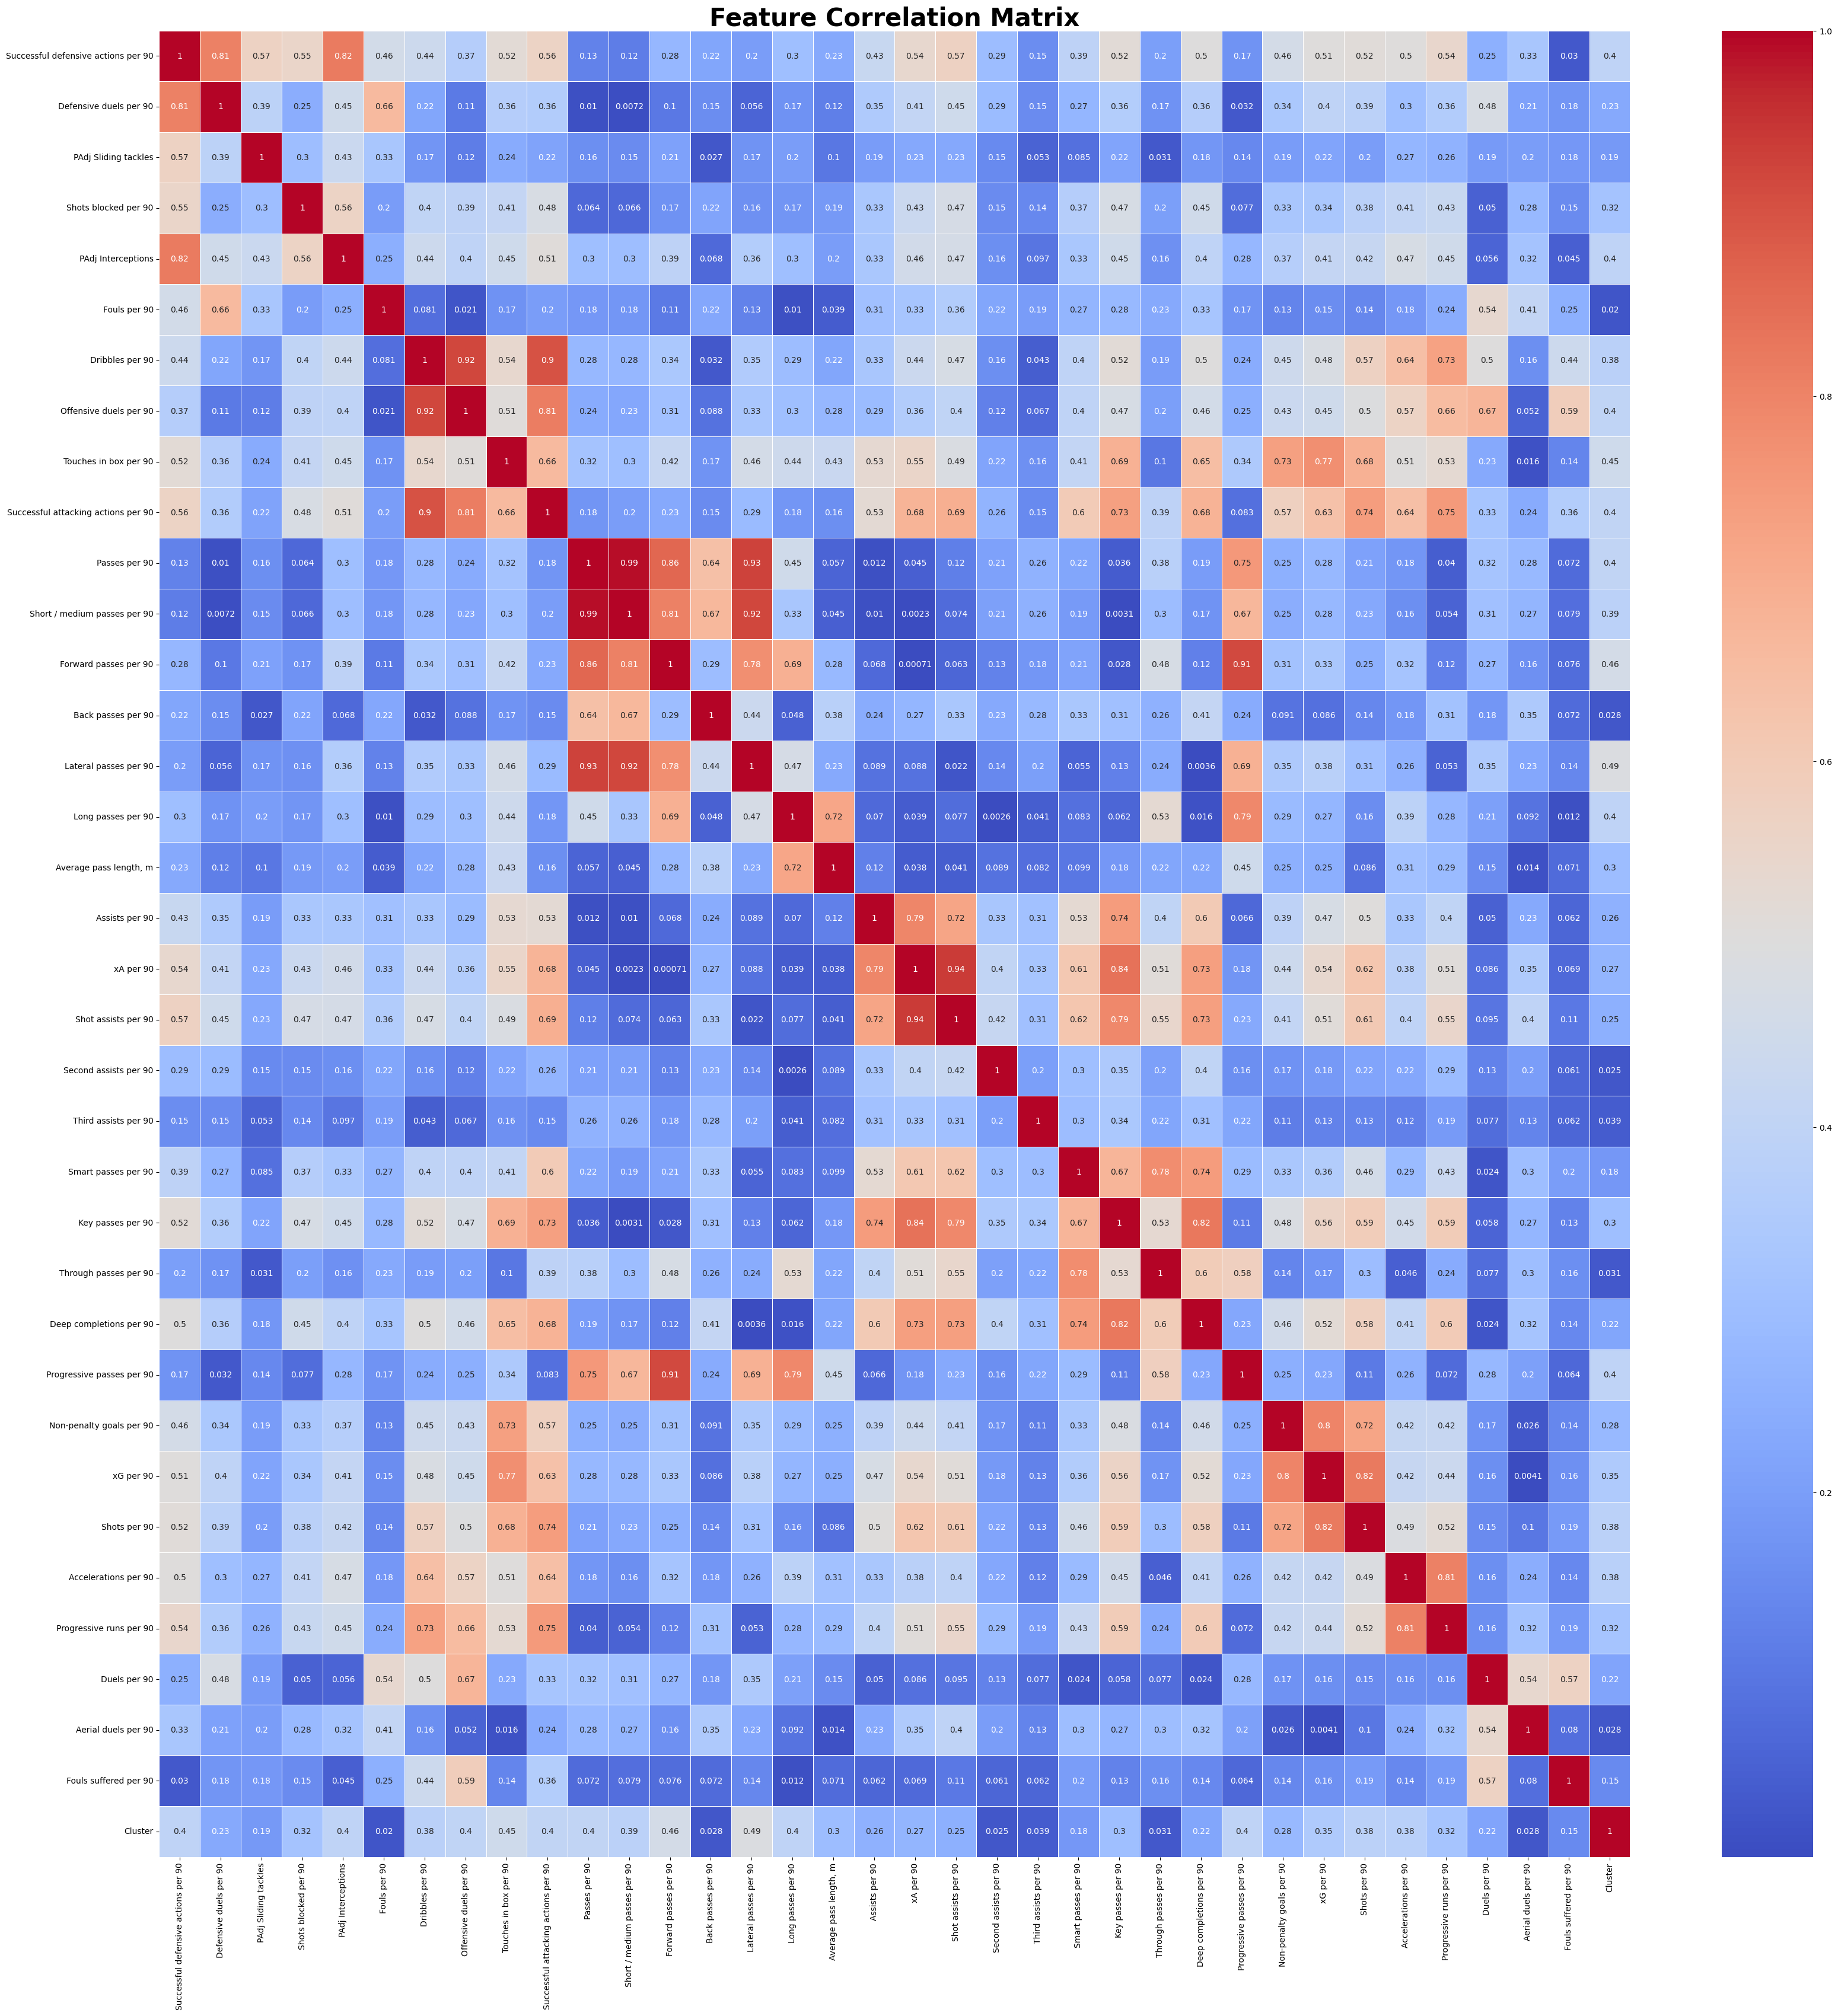

In [224]:
# Visualizing the correlation matrix with a heatmap
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=30, fontweight='bold')
plt.show()

The correlations we are seeing are logically expected, because many of these features are mechanistically linked (i.e., one causes or contributes to another).

### **Defensive Metrics Highly Correlated:**

* **Successful Defensive Actions per 90 & Defensive Duels per 90:**
Players who engage in more defensive duels (attempts to dispossess an opponent) are likely to have a higher number of successful defensive actions, as these duels contribute directly to defensive success.​

* **Successful Defensive Actions per 90 & PAdj Interceptions:**
A higher number of successful defensive actions often includes a significant number of interceptions. Possession-adjusted (PAdj) interceptions account for team possession, indicating that players on teams with less possession have more opportunities for defensive actions, leading to this correlation.

### **Attacking Metrics Highly Correlated:**

* **Dribbles per 90 & Offensive Duels per 90:**
Dribbling involves taking on opponents, which constitutes offensive duels. Therefore, players who dribble more frequently engage in more offensive duels.​

* **Dribbles per 90 & Successful Attacking Actions per 90:**
Successful dribbles contribute to successful attacking actions, such as advancing the ball or creating opportunities, leading to this correlation.​

* **Dribbles per 90 & Progressive Runs per 90:**
Dribbling often results in progressive runs, where the ball is moved significantly towards the opponent's goal, explaining the strong relationship between these metrics.​

* **Touches in Box per 90 & Non-Penalty Goals per 90:**
Players with more touches in the opponent's penalty area are positioned closer to goal-scoring opportunities, naturally leading to a higher number of non-penalty goals.​

* **Touches in Box per 90 & xG per 90:**
More touches in the box increase the likelihood of high-quality shooting opportunities, reflected in a higher expected goals (xG) value.​

* **Successful Attacking Actions per 90 & Key Passes per 90/Shots per 90/Progressive Runs per 90:**
Successful attacking actions encompass key passes, shots, and progressive runs, indicating that players effective in attack contribute across these areas.

### **Passing Metrics Highly Correlated:**

* **Passes per 90 & Short/Medium Passes per 90/Forward Passes per 90/Lateral Passes per 90/Progressive Passes per 90:**
A higher total number of passes naturally includes more short/medium, forward, lateral, and progressive passes, leading to strong correlations among these metrics.​

* **Forward Passes per 90 & Progressive Passes per 90:**
Forward passes often advance the ball significantly, qualifying as progressive passes, hence the correlation.​

* **Long Passes per 90 & Average Pass Length:**
An increase in long passes directly affects the average pass length, as more long passes raise the overall average.

### **Assist Metrics Highly Correlated:**

* **Assists per 90 & xA per 90/Shot Assists per 90/Key Passes per 90:**
Assists are directly related to expected assists (xA), shot assists, and key passes, as all these metrics measure the creation of goal-scoring opportunities.​

* **xA per 90 & Deep Completions per 90:**
Expected assists are influenced by passes that penetrate deep into the opponent's defensive area, known as deep completions, which often lead to goal-scoring chances.​

* **Smart Passes per 90 & Through Passes per 90/Deep Completions per 90:**
Smart passes, which break defensive lines, often manifest as through passes and lead to deep completions, explaining these correlations.

### **Shooting Metrics Highly Correlated:**

* **Non-Penalty Goals per 90 & xG per 90/Shots per 90:**
A higher number of shots and a higher expected goals value typically result in more non-penalty goals, as players creating and taking more chances are likely to score more.​

* **xG per 90 & Shots per 90:**
More shots generally lead to a higher cumulative expected goals value, reflecting the quantity and quality of shooting opportunities.

### **Movement Metrics Highly Correlated:**

* **Accelerations per 90 & Progressive Runs per 90:**
Frequent accelerations often lead to progressive runs, where players advance the ball significantly towards the opponent's goal

# **Whole Process applying Variance Thresholding after the normalization**

We can remove low-variance features and follow the same procedure. Low-variance features often contribute minimally to clustering. By applying a Variance Threshold, we retain features with higher variability, ensuring the clustering process focuses on impactful metrics. For the purposes of this analysis, we present this as a viable alternative, without delving further into it.

We remove low variance Features. These features contribute minimally to clustering and can obscure meaningful insights. Using a dynamic threshold, we retain features with significant variability, ensuring the analysis focuses on impactful metrics.

In [225]:
# Analyzing feature variance to remove low-variance features
print(f"Original number of Features: {len(players.columns)}\n")

# Calculating variances across features
variances = np.var(X_norm, axis=0)

# Setting dynamic threshold for removing low-variance features
thresh = np.percentile(variances, 35)  # Remove lowest 35% or 25% of variance

# Applying Variance Threshold for feature selection
selector = VarianceThreshold(threshold=thresh)
X_selected = selector.fit_transform(X_norm)

# Get selected features
selected_features = X_norm.columns[selector.get_support()]
print(f"Selected Features (VarianceThreshold):\n {selected_features}\n")
print(f"Number of Selected Features (VarianceThreshold): {len(selected_features)}\n")

# Get not-selected features
not_selected_features = X_norm.columns[~selector.get_support()]
print(f"Not Selected Features (VarianceThreshold):\n {not_selected_features}\n")
print(f"Number of Not Selected Features (VarianceThreshold): {len(not_selected_features)}")

Original number of Features: 35

Selected Features (VarianceThreshold):
 Index(['Defensive duels per 90', 'PAdj Sliding tackles',
       'Shots blocked per 90', 'Fouls per 90', 'Offensive duels per 90',
       'Touches in box per 90', 'Successful attacking actions per 90',
       'Passes per 90', 'Short / medium passes per 90', 'Back passes per 90',
       'Lateral passes per 90', 'Long passes per 90', 'Assists per 90',
       'xA per 90', 'Shot assists per 90', 'Second assists per 90',
       'Third assists per 90', 'Smart passes per 90', 'Key passes per 90',
       'Deep completions per 90', 'Progressive passes per 90',
       'Non-penalty goals per 90', 'xG per 90', 'Shots per 90',
       'Accelerations per 90', 'Progressive runs per 90',
       'Aerial duels per 90', 'Fouls suffered per 90', 'Cluster'],
      dtype='object')

Number of Selected Features (VarianceThreshold): 29

Not Selected Features (VarianceThreshold):
 Index(['Successful defensive actions per 90', 'PAdj Intercept

In [226]:
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)
X_selected_df.head()

,Defensive duels per 90,PAdj Sliding tackles,Shots blocked per 90,Fouls per 90,Offensive duels per 90,Touches in box per 90,Successful attacking actions per 90,Passes per 90,Short / medium passes per 90,Back passes per 90,...,Deep completions per 90,Progressive passes per 90,Non-penalty goals per 90,xG per 90,Shots per 90,Accelerations per 90,Progressive runs per 90,Aerial duels per 90,Fouls suffered per 90,Cluster
0,1.909615,2.034015,0.120401,2.625590,0.726382,0.897849,-0.019083,0.005063,0.145786,0.989933,...,-0.076632,-1.495870,1.153633,0.331559,-0.459383,0.033379,1.528004,0.835866,0.492119,4.0
1,-0.199143,0.116153,0.120401,0.642216,-1.054544,-0.989498,-0.827877,-1.123216,-1.162176,-1.898259,...,-1.329345,-0.478589,-0.997458,-1.093592,-1.307682,-0.695298,-1.306032,0.279842,-0.281145,1.0
2,0.357421,0.183843,0.737435,1.187099,-1.165160,-1.206434,-1.532004,-1.213379,-1.302097,-0.696666,...,-0.957446,-1.230493,-0.997458,-0.974829,-1.562172,-1.278240,-1.514417,0.337611,-0.865807,1.0
3,0.357421,0.161280,0.531757,-0.643708,-0.110616,0.019257,-0.666118,-0.631869,-0.546869,-0.334004,...,-0.409384,-0.450945,-0.029467,-0.499779,-0.306689,0.004232,0.013740,0.496475,-0.130264,1.0
4,-1.466871,-0.132040,-0.565192,-0.752685,0.589955,4.075968,3.653795,1.056414,0.848001,1.579806,...,4.562319,1.196608,2.121624,1.281660,3.731214,1.549029,1.805851,-1.005512,-0.469745,3.0


We follow the same steps as before. The rest of the code is the same.

In [227]:
# Computing correlation matrix for selected features
corr_matrix = X_selected_df.corr().abs()

# Identifying highly correlated feature pairs
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and corr_matrix[i][j] > 0.7]

# Displaying highly correlated feature pairs
print("Highly Correlated Features (Over 0.7):\n")
for pair in high_corr_pairs:
    print(f"{pair[0]} | {pair[1]}\n")

Highly Correlated Features (Over 0.7):

Offensive duels per 90 | Successful attacking actions per 90

Touches in box per 90 | Non-penalty goals per 90

Touches in box per 90 | xG per 90

Successful attacking actions per 90 | Offensive duels per 90

Successful attacking actions per 90 | Key passes per 90

Successful attacking actions per 90 | Shots per 90

Successful attacking actions per 90 | Progressive runs per 90

Passes per 90 | Short / medium passes per 90

Passes per 90 | Lateral passes per 90

Passes per 90 | Progressive passes per 90

Short / medium passes per 90 | Passes per 90

Short / medium passes per 90 | Lateral passes per 90

Lateral passes per 90 | Passes per 90

Lateral passes per 90 | Short / medium passes per 90

Long passes per 90 | Progressive passes per 90

Assists per 90 | xA per 90

Assists per 90 | Shot assists per 90

Assists per 90 | Key passes per 90

xA per 90 | Assists per 90

xA per 90 | Shot assists per 90

xA per 90 | Key passes per 90

xA per 90 | Deep

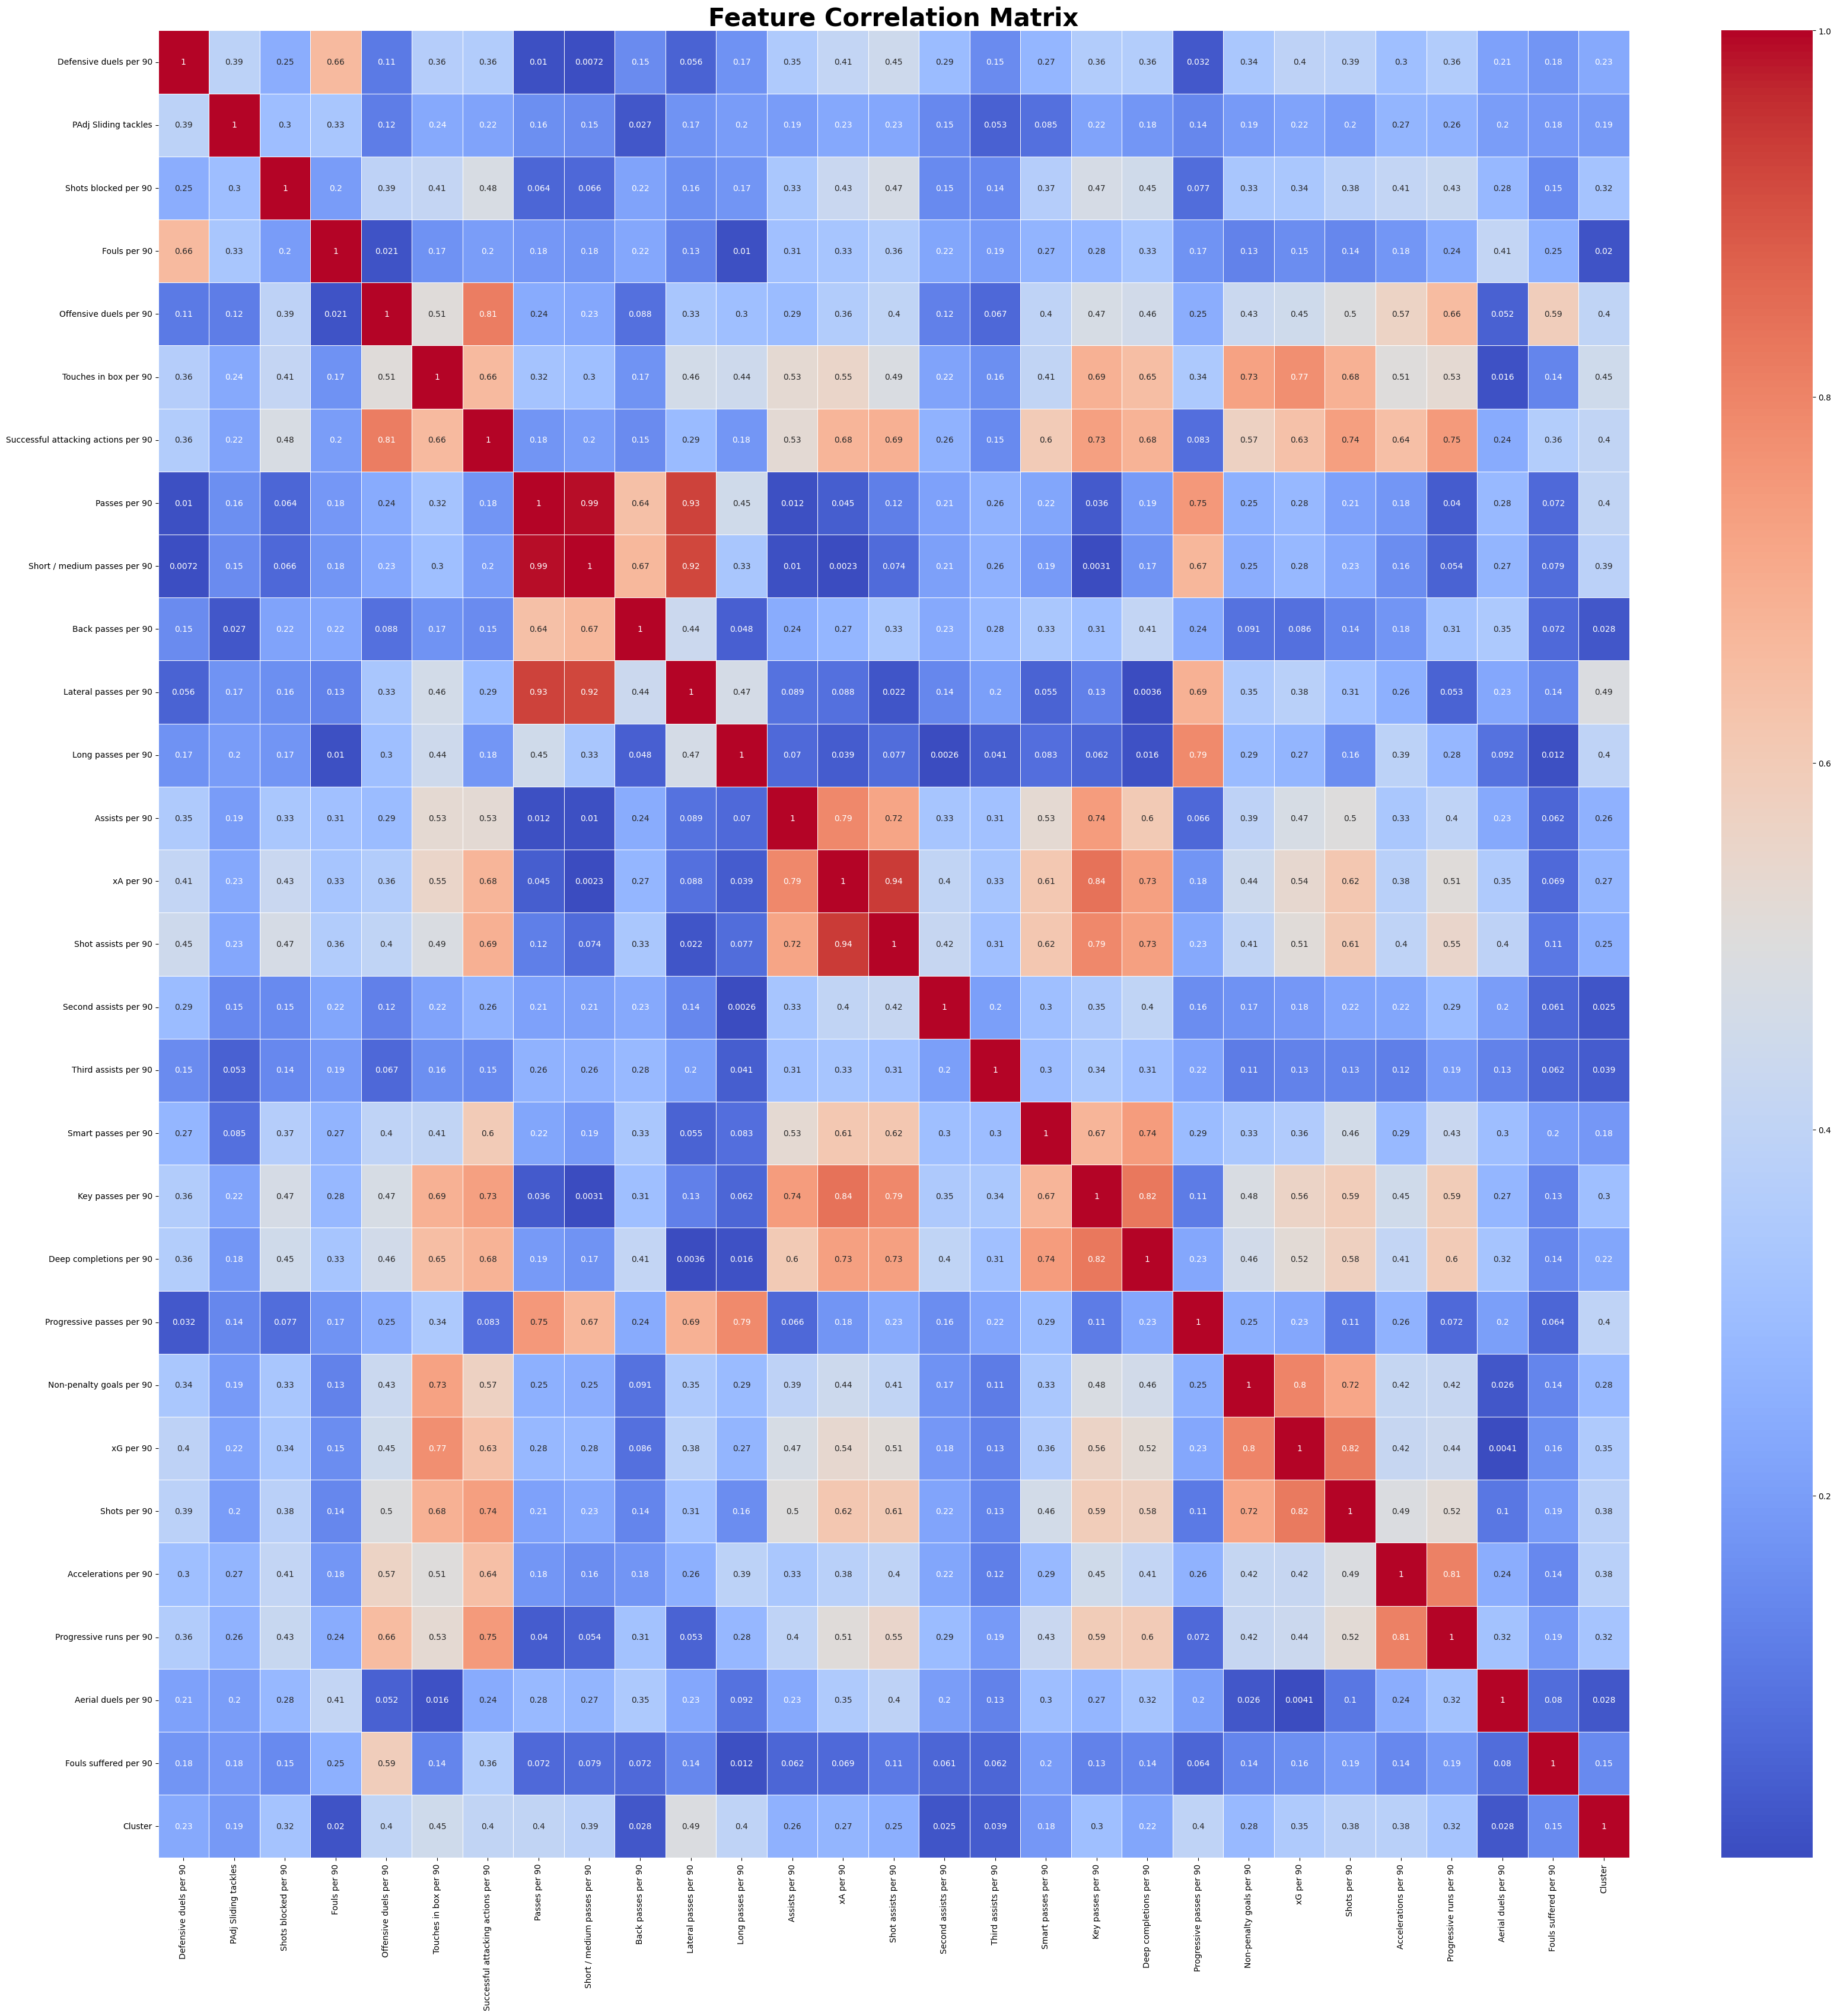

In [228]:
# Visualizing the correlation matrix with a heatmap
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Matrix", fontsize=30, fontweight='bold')
plt.show()

In [229]:
# Applying PCA to reduce the dataset to two dimensions for visualization and clustering
pca = PCA(n_components = 2)
reduced_data = pca.fit_transform(X_selected_df)

# Creating a DataFrame for the reduced dimensions
reduced = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced.head()

,PC1,PC2
0,0.586244,-1.874382
1,-3.583959,-2.020949
2,-4.308777,-2.297367
3,-1.386072,-1.540684
4,14.265927,6.661649


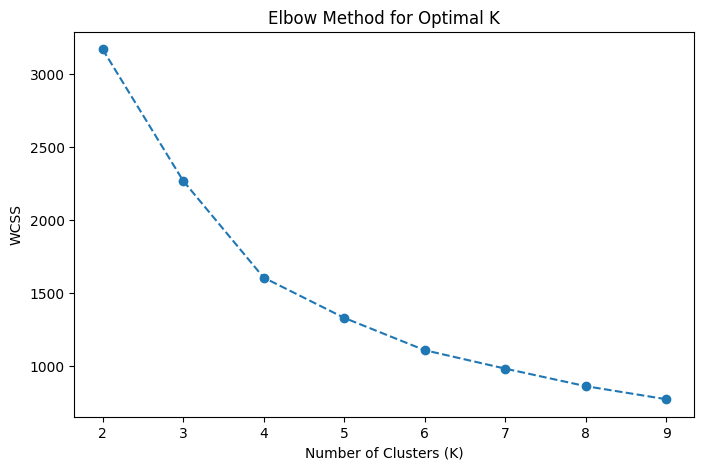


Optimal K (KneeLocator): 4


In [230]:
# Compute WCSS for multiple k values
wcss = []
k_values = range(2, 10)

# Iterate through different cluster numbers
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', n_init=10)
    kmeans.fit(reduced)
    wcss.append(kmeans.inertia_)

# Find optimal k using KneeLocator
kneedle = KneeLocator(list(k_values), wcss, curve="convex", direction="decreasing")
optimal_k_elbow = kneedle.elbow

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()

print(f"\nOptimal K (KneeLocator): {optimal_k_elbow}")

In [231]:
# Performing KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k_elbow, random_state=42, init='k-means++', n_init=10)
kmeans = kmeans.fit(reduced)

# Assigning cluster labels to each data point
labels = kmeans.predict(reduced)
clusters = kmeans.labels_.tolist()

In [232]:
# Add cluster labels to the reduced dataset
reduced['Cluster'] = clusters
reduced['Player'] = player_names
reduced['Position'] = player_positions
reduced.columns = ['x', 'y', 'Cluster', 'Player', 'Position']
reduced.head()

,x,y,Cluster,Player,Position
0,0.586244,-1.874382,3,Gavi,"RCMF, LCMF, LAMF"
1,-3.583959,-2.020949,0,K. N'Doram,"DMF, LDMF"
2,-4.308777,-2.297367,0,R. Khedira,"DMF, LCMF, RCMF"
3,-1.386072,-1.540684,0,P. Osterhage,"LDMF, DMF, LCMF"
4,14.265927,6.661649,1,K. De Bruyne,"AMF, RCMF"


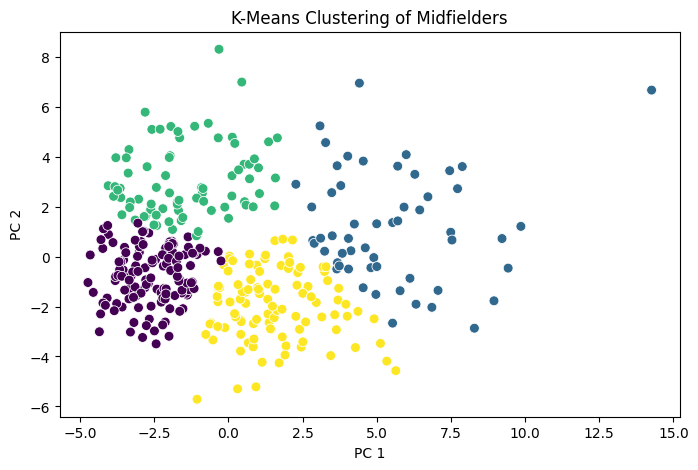

In [233]:
# Visualizing clustering results with selected features
plt.figure(figsize=(8, 5))
scatter_plot=sns.scatterplot(x='x', y='y', data=reduced, legend=False, hue=reduced['Cluster'], palette='viridis', s=50)
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("K-Means Clustering of Midfielders")
plt.show()

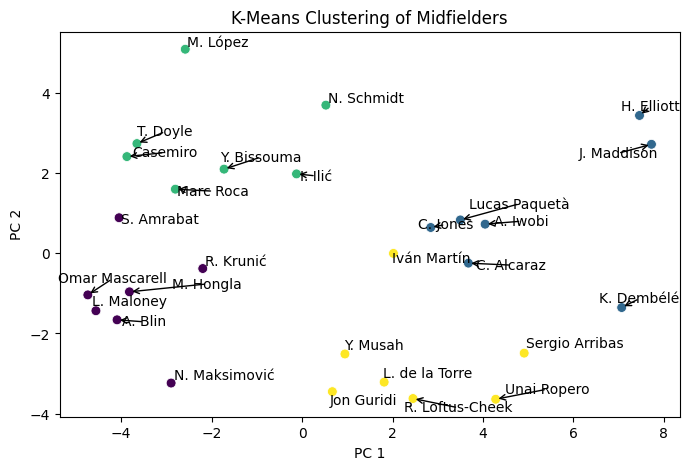

In [234]:
# Select a subset of players for visualization
# Number of players to select per cluster
n_players_per_cluster = 7  # Or any desired number

# Sample from each cluster separately and concatenate
vis_sample = pd.concat([
    group.sample(n=n_players_per_cluster, random_state=42)
    for _, group in reduced.groupby('Cluster')
])

# Visualizing the clusters using first 2 PCA components
plt.figure(figsize=(8, 5))
sns.scatterplot(x='x', y='y', data=vis_sample, legend=False, hue=vis_sample['Cluster'], palette='viridis', s=50)

texts = []
for x, y, s in zip(vis_sample.x, vis_sample.y, vis_sample.Player):
    texts.append(plt.text(x, y, s))

#Adjust text
adjust_text(texts, strategy='best', expand_points=(1.2, 1.2),
            expand_text=(1.2, 1.2), arrowprops=dict(arrowstyle='->', color='black'))

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('K-Means Clustering of Midfielders')
plt.show()

In [235]:
for cluster in range(optimal_k_elbow):
    cluster_players = vis_sample[vis_sample["Cluster"] == cluster][["Player", "Cluster", "Position"]].reset_index(drop=True)
    print(f"\nCluster {cluster}:")
    print(cluster_players)


Cluster 0:
           Player  Cluster          Position
0      S. Amrabat        0     DMF, LDMF, LB
1         A. Blin        0  RDMF, RCMF, LCMF
2       M. Hongla        0   RCMF, LCMF, DMF
3      L. Maloney        0   DMF, RCMF, RDMF
4   N. Maksimović        0        LCMF, RCMF
5  Omar Mascarell        0   DMF, RCMF, LCMF
6       R. Krunić        0   DMF, RDMF, RCMF

Cluster 1:
          Player  Cluster          Position
0  Lucas Paquetà        1     AMF, LAMF, LW
1    J. Maddison        1               AMF
2       A. Iwobi        1  LCMF, RAMF, LAMF
3       C. Jones        1              LCMF
4     C. Alcaraz        1   LCMF, RCMF, AMF
5     H. Elliott        1         RCMF, RWF
6     K. Dembélé        1    RCMF, RWF, AMF

Cluster 2:
        Player  Cluster          Position
0    Marc Roca        2   LDMF, LCB, LCMF
1   N. Schmidt        2         RCMF, AMF
2  Y. Bissouma        2   LDMF, DMF, RDMF
3      I. Ilić        2              LCMF
4     M. López        2  RDMF, RCMF, LDMF


In [236]:
# Calculating internal clustering evaluation metrics
sil_score = silhouette_score(reduced[['x', 'y']], labels)
db_score = davies_bouldin_score(reduced[['x', 'y']], labels)

print(f"Silhouette Score: {sil_score:.4f}")
print(f"Davies-Bouldin Score: {db_score:.4f}")

Silhouette Score: 0.3876
Davies-Bouldin Score: 0.8819


In [237]:
# Adding cluster labels to the normalized dataset
X_norm['Cluster'] = labels

# Calculating average feature statistics for each cluster
cluster_summary = X_norm.groupby('Cluster').mean()
cluster_summary

,Successful defensive actions per 90,Defensive duels per 90,PAdj Sliding tackles,Shots blocked per 90,PAdj Interceptions,Fouls per 90,Dribbles per 90,Offensive duels per 90,Touches in box per 90,Successful attacking actions per 90,...,Deep completions per 90,Progressive passes per 90,Non-penalty goals per 90,xG per 90,Shots per 90,Accelerations per 90,Progressive runs per 90,Duels per 90,Aerial duels per 90,Fouls suffered per 90
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.705845,0.513496,0.290410,0.541778,0.523701,0.403808,-0.559950,-0.554103,-0.546947,-0.712889,...,-0.704795,-0.235453,-0.504362,-0.532667,-0.579711,-0.588575,-0.701608,0.010335,0.376105,-0.150139
1,-1.143207,-0.862185,-0.576328,-0.980287,-0.941243,-0.724153,1.187530,1.094500,1.260528,1.479479,...,1.669692,0.197521,0.952213,1.225517,1.294591,0.910442,1.262787,0.139122,-0.592728,0.369357
2,0.230174,0.066379,0.180987,0.211525,0.418519,-0.286431,-0.428937,-0.409328,-0.603680,-0.343925,...,0.061622,1.116827,-0.369830,-0.462196,-0.428458,-0.317124,-0.107070,-0.497024,-0.387423,-0.210240
3,-0.466012,-0.243350,-0.201517,-0.328968,-0.488869,0.098627,0.409557,0.437355,0.489751,0.380934,...,-0.050276,-0.678060,0.419919,0.379770,0.376318,0.509834,0.299152,0.299700,0.141712,0.156559


In [238]:
# Extracting PCA loadings to interpret feature contributions
pca_loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=[f for f in selected_features if f != 'Player' and f!= 'Position'])

# Adding absolute values for easier comparison
pca_loadings[['Abs_PC1', 'Abs_PC2']] = pca_loadings[['PC1', 'PC2']].abs()

# Displaying the DataFrame
pca_loadings

,PC1,PC2,Abs_PC1,Abs_PC2
Defensive duels per 90,-0.159840,-0.053472,0.159840,0.053472
PAdj Sliding tackles,-0.106076,0.027497,0.106076,0.027497
Shots blocked per 90,-0.182340,-0.012685,0.182340,0.012685
Fouls per 90,-0.103099,-0.150237,0.103099,0.150237
Offensive duels per 90,0.208690,-0.090882,0.208690,0.090882
Touches in box per 90,0.255231,-0.098352,0.255231,0.098352
Successful attacking actions per 90,0.275110,-0.010813,0.275110,0.010813
Passes per 90,-0.053782,0.388722,0.053782,0.388722
Short / medium passes per 90,-0.055771,0.371310,0.055771,0.371310
Back passes per 90,0.086890,0.245556,0.086890,0.245556


In [239]:
# Sorting features by their contribution to PC1
top_features_pc1 = pca_loadings[['Abs_PC1', 'PC1', 'PC2']].sort_values(by=['Abs_PC1'], ascending=False)
top_features_pc1

,Abs_PC1,PC1,PC2
Successful attacking actions per 90,0.275110,0.275110,-0.010813
Key passes per 90,0.264061,0.264061,0.104533
Touches in box per 90,0.255231,0.255231,-0.098352
xA per 90,0.252101,0.252101,0.129066
Shots per 90,0.249549,0.249549,-0.037961
Shot assists per 90,0.248882,0.248882,0.154927
Deep completions per 90,0.247593,0.247593,0.158445
Cluster,0.243435,0.243435,-0.288374
xG per 90,0.236530,0.236530,-0.079830
Progressive runs per 90,0.233525,0.233525,0.045777


In [240]:
# Sorting features by their contribution to PC2
top_features_pc2 = pca_loadings[['Abs_PC2', 'PC2', 'PC1']].sort_values(by=['Abs_PC2'], ascending=False)
top_features_pc2

,Abs_PC2,PC2,PC1
Passes per 90,0.388722,0.388722,-0.053782
Short / medium passes per 90,0.371310,0.371310,-0.055771
Lateral passes per 90,0.356439,0.356439,-0.103156
Progressive passes per 90,0.350294,0.350294,-0.045175
Cluster,0.288374,-0.288374,0.243435
Back passes per 90,0.245556,0.245556,0.086890
Long passes per 90,0.234221,0.234221,-0.093742
Aerial duels per 90,0.187518,-0.187518,-0.086650
Smart passes per 90,0.166924,0.166924,0.200630
Third assists per 90,0.163126,0.163126,0.082101


In [241]:
pca_loadings[pca_loadings['Abs_PC1'] > pca_loadings['Abs_PC2']].sort_values(by=['Abs_PC1'], ascending=False)

,PC1,PC2,Abs_PC1,Abs_PC2
Successful attacking actions per 90,0.275110,-0.010813,0.275110,0.010813
Key passes per 90,0.264061,0.104533,0.264061,0.104533
Touches in box per 90,0.255231,-0.098352,0.255231,0.098352
xA per 90,0.252101,0.129066,0.252101,0.129066
Shots per 90,0.249549,-0.037961,0.249549,0.037961
Shot assists per 90,0.248882,0.154927,0.248882,0.154927
Deep completions per 90,0.247593,0.158445,0.247593,0.158445
xG per 90,0.236530,-0.079830,0.236530,0.079830
Progressive runs per 90,0.233525,0.045777,0.233525,0.045777
Assists per 90,0.220200,0.094908,0.220200,0.094908


In [242]:
pca_loadings[pca_loadings['Abs_PC2'] > pca_loadings['Abs_PC1']].sort_values(by=['Abs_PC2'], ascending=False)

,PC1,PC2,Abs_PC1,Abs_PC2
Passes per 90,-0.053782,0.388722,0.053782,0.388722
Short / medium passes per 90,-0.055771,0.371310,0.055771,0.371310
Lateral passes per 90,-0.103156,0.356439,0.103156,0.356439
Progressive passes per 90,-0.045175,0.350294,0.045175,0.350294
Cluster,0.243435,-0.288374,0.243435,0.288374
Back passes per 90,0.086890,0.245556,0.086890,0.245556
Long passes per 90,-0.093742,0.234221,0.093742,0.234221
Aerial duels per 90,-0.086650,-0.187518,0.086650,0.187518
Third assists per 90,0.082101,0.163126,0.082101,0.163126
Fouls per 90,-0.103099,-0.150237,0.103099,0.150237


Comparing clustering results before and after feature selection highlights the impact of variance thresholding. Reduced-feature clustering may improve interpretability and avoid overfitting by focusing on impactful metrics.